<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Image_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b> How to use PISTA for image simulation</b></h1>

# **Initialize**

In [2]:
!pip install insist-pista --quiet
!pip install artpop --quiet
!pip install galsim --quiet

     |████████████████████████████████| 10.4 MB 6.1 MB/s 
     |████████████████████████████████| 826 kB 43.3 MB/s 
     |████████████████████████████████| 8.4 MB 23.8 MB/s 
     |████████████████████████████████| 59.9 MB 99 kB/s 
     |████████████████████████████████| 344 kB 52.6 MB/s 
     |████████████████████████████████| 6.6 MB 8.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 43.7 MB 1.3 MB/s 
     |████████████████████████████████| 213 kB 76.8 MB/s 


In [15]:
import pista as pis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

import astropy.units as u
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

import seaborn as sb

In [23]:
data_path = Path(pis.__file__).parent.joinpath() # Path to package data
data_path

PosixPath('/usr/local/lib/python3.7/dist-packages/pista')

In [ ]:
# artpop's matplotlib style
plt.style.use(art.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(100)

# **Python Image Simulation and Testing Application (PISTA)**

PISTA package allows user to simulate resolved stellar population using source catalog and detector characteristics. This notebook contains few examples on how to use PISTA

## **Step 1**
Upload a dataframe with columns 'ra', 'dec', 'mag'.

In [3]:
from google.colab import files

uploaded = files.upload()

Saving phatm31.fits to phatm31.fits


In [14]:
ls # Shows the files in the current working directory

phatm31.fits  sample_data/


In [16]:
tab = Table.read('phatm31.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame
df

,ra,dec,mag,s_F275W
0,11.058884,41.343124,19.441000,110.800003
1,11.060650,41.343782,24.539000,5.200000
2,11.061190,41.343785,21.142000,46.599998
3,11.061413,41.345837,24.612000,6.000000
4,11.061744,41.343196,22.931000,17.700001
...,...,...,...,...
534,11.071035,41.358390,24.594000,5.700000
535,11.071245,41.358205,24.337999,6.900000
536,11.071255,41.358967,20.018000,84.300003
537,11.071642,41.359526,24.660999,5.400000


## **Step 2**

Create a dictionary object with telescope parameters.

Dictionary structure
       
```
tel_params : dict, 
 |                   {'aperture'       : float,  cm
 |                    'pixel_scale'    : float,  arcsecs/pixels
 |                    'sim_file'       : fits,npy 
 |                    'response_funcs' : list, [filename.dat, n] where n is 
 |                                            number of times to multiply filter
 |                                            profile
 |                    'coeffs'         : float, filter coefficients if not
 |                                            response_funcs
 |                    } 
```

aperture : aperture of the primary mirror in cms <br>
pixel_scale : Pixel scale on the detector <br>
sim_file    : path to file containing point spread function data in the form of <br> 2D array. User can use both npy or FITS data. <br>
response_funcs : Dictionary containing paths to filter, dichroic, coating efficiency, quantum efficieny etc. profiles.<br>
Format for dictionary is [\<path>, \<multiplicity factor>]<br>
Multiplicity factor : number of times a component is repeated.<br>

For example if filter is used once and dichoric is used twice in the photometric system then list will be:<br>
```
response_funcs = [
                   '..\path\coating.dat,1',
                   '..\path\dichroic.dat,2'
                 ]
                 
```

coeffs : response coefficient. If user doesn't wanna use filter and response function profiles. They can directly enter the total multiplicate factor that needs to go into the effective area. Such that coeff = c1*c2*c3*.. 

Where c1,c2,c3 are response function coefficients

In the example below we will use the PISTA package data 

In [39]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/data/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1',    
                                  f'{data_path}/data/INSIST/UV/Coating.dat,5',   # 5 mirrors
                                 f'{data_path}/data/INSIST/UV/Dichroic.dat,2',   # 2 dichroics
                                 f'{data_path}/data/INSIST/UV/QE.dat,1'
                                ],                                
            } 

## **Step 3**

Initialize PISTA Analyzer object

n_x : Number of pixels along RA direction. <br>
n_y : Number of pixels along Dec direction <br>
exp_time : Exposure time in seconds

In [40]:
sim = pis.Analyzer(df = df,tel_params = tel_params, n_x = 800, n_y = 800, 
                   exp_time = 100)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdf84104b50>)

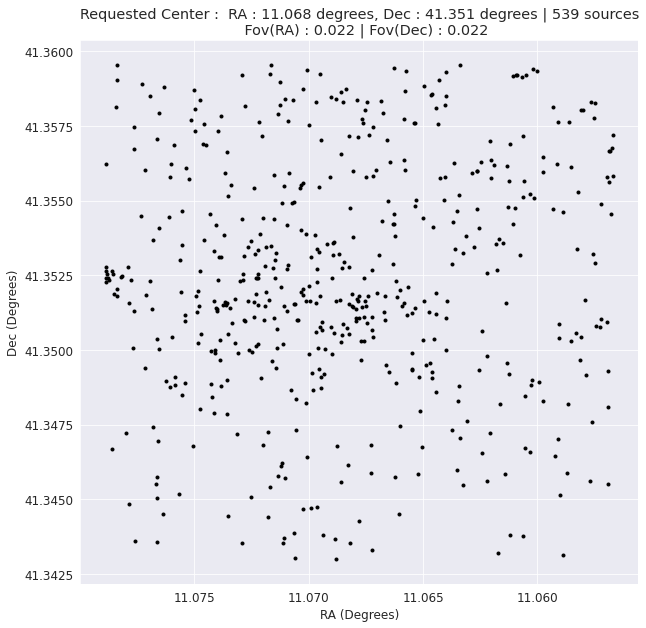

In [41]:
sim.show_field () # Displays the RA-Dec scatter of sources withing the Field of View

## **Step 4**

Create dictionary object with Detector parameters

```
det_params: dict, optional  
        Dictionary contianing detector parameters. The default is None.
                   {     'shot_noise' :  str,
                         'M_sky'      :  float,
                         'qe_mean'    :  float, [0,1] To be used if QE profile is not given
                         'qe_sigma'   :  float,       Pixel to pixel fluctuation
                         'bias'       :  float,       electrons
                         'G1'         :  float,
                         'bit_res'    :  int,         
                         'RN'         :  float,       elec/pix
                         'PRNU_frac'  :  float,       PRNU sigma
                         'T'          :  float,       K
                         'DFM'        :  float,       pA
                         'pixel_area' :  float,       
                         'DN'         :  float,     
                         'NF'         :  float,       electrons 
                         'FWC'        :  float,       electrons 
                         'C_ray_r'    :  float        hits/second
                     }
```


shot_noise : Distribuition to be used for shot_noise, 'Gaussian' or 'Possonian' <br>
M_sky : sky magnitude in ABmag/arcsecond^2. If filter profiles are not used.<br>
qe_mean : Mean Quantum efficiency of the detector [0,1], To be use if QE responce function is not given. <br>
qe_sigma : standard deviation of quantum efficiency across pixel on the detector. <br>
bias : detector offset in electrons<br>
G1   : Detector gain<br>
bit_res : bit resolution of the detector<br>
RN      : Read noise of the detector in electrons<br>
PRNU_frac: Photon Responce non uniformity fraction<br>
T        : Temperature of the detector in Kelvin <br>
DFM      : Dark Current figure of meric in unit [   ] <br>
pixel_area : area of pixel in cm^2 <br>
DN   : Dark Current fixed pattern fraction <br>
NF   : Noise floor in electrons<br>
C_ray_r' cosmic ray hits rate hits/second/arcsecond**2

In [43]:
det_params = {     'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  225,        
                  'DN'         :  0.1/100     
                     }

## **Step 4**

Run simulation by calling the sim object with required arguments

In [44]:
sim(det_params = det_params)

Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/pista/analysis.py:88: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)


(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7fdf832f4410>)

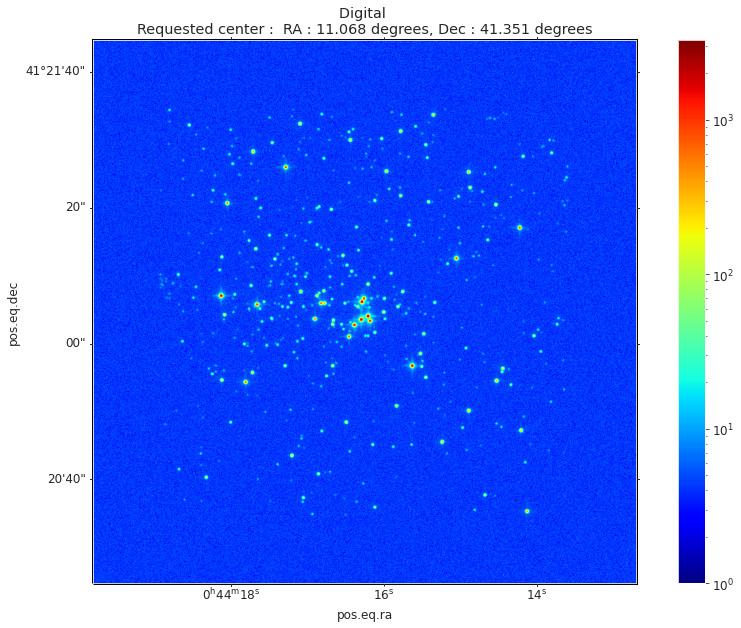

In [45]:
sim.show_image() # Displays the final simulated digital image

(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7fdf805adb10>)

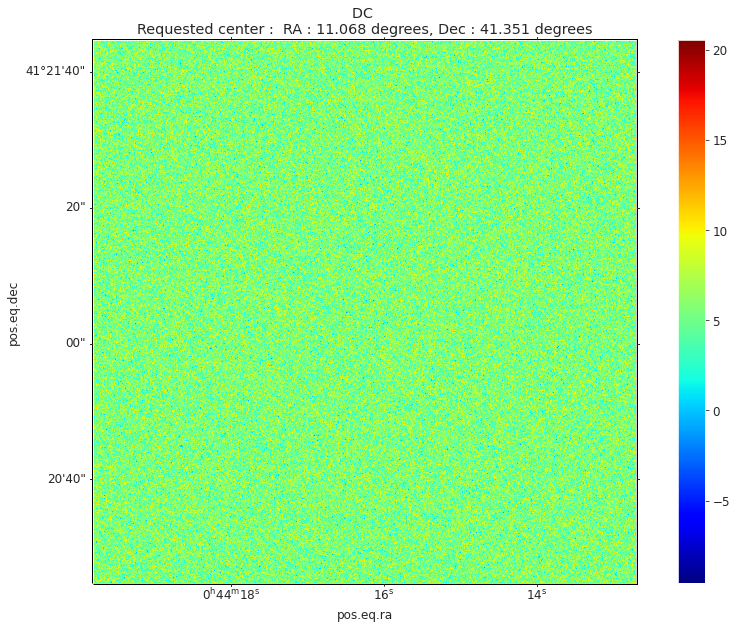

In [48]:
sim.show_image('DC') # Shows dark current frame 

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdf7ec708d0>)

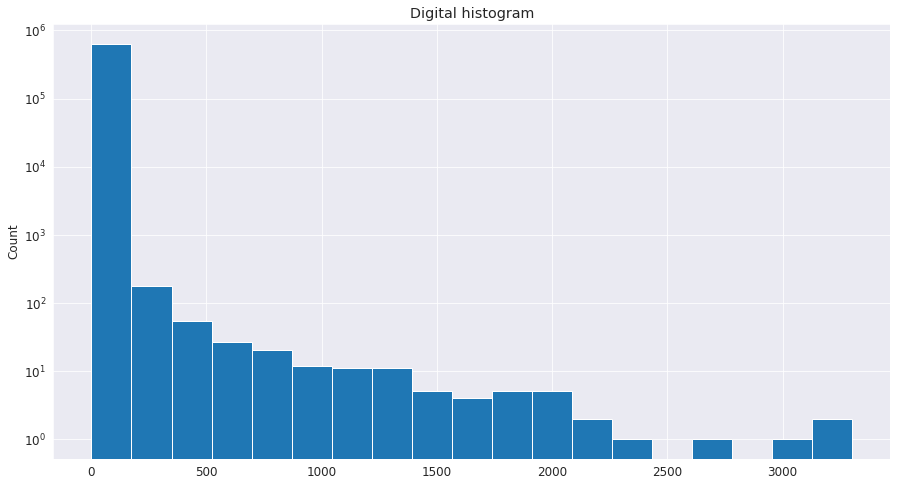

In [49]:
sim.show_hist() # Shows histogram of final image

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdf7eb6e750>)

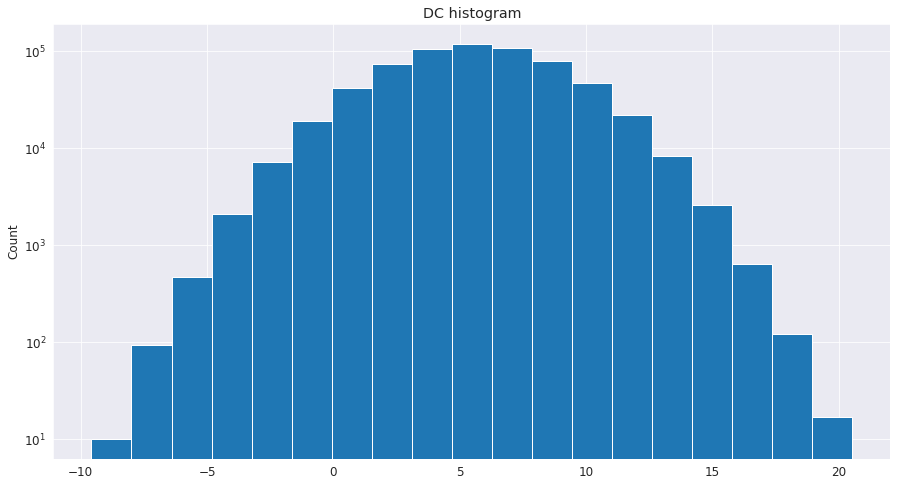

In [50]:
sim.show_hist('DC') #Shows histogram of dark current frame

In [51]:
sim.phot_table # Displays table with aperture photometry of the image

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_out,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
1,638.0,105.0,3577.9488548406944,961.674765286243,161.47524043985425,3416.4736144008402,59.81595819545729,57.11642373490062,19.441,19.054507266753284,0.018943763093816585
2,591.0,128.0,149.69880937557895,868.3958860095985,145.8127420538505,3.886067321728433,12.235146479530965,0.3176151040144642,24.539,26.41467664426047,3.4066389989775985
3,576.0,129.0,844.26631435715,878.6459531561209,147.53383541800537,696.7324789391446,29.0562611902693,23.978738158248472,21.142,20.780787303951303,0.0451233085268835
4,570.0,202.0,148.78646382277685,866.2299475493211,145.44905835716213,3.3374054656147223,12.19780569704145,0.27360703625769367,24.612,26.579930012120258,3.954576661474929
5,561.0,107.0,260.48764654734316,849.9078463889828,142.7084070429262,117.77923950441695,16.139629690527077,7.297518082062674,22.931,22.710780579807736,0.14826958807537044
6,552.0,253.0,2995.0743174481468,925.4743503671052,155.39681256164081,2839.677504886506,54.727272154275575,51.88779548305435,19.638,19.25527989147899,0.02085268780311475
7,549.0,195.0,186.68556403413587,874.781867627439,146.88501508669685,39.80054894743901,13.66329257661329,2.9129544525426785,23.764,23.888729788977034,0.37144418755176106
8,543.0,228.0,383.5788113201955,877.3466637439149,147.3156711510305,236.26314016916498,19.5851681463345,12.063370526302235,22.216,21.954962514571577,0.08969300890168909


# **ArtPop**


In [ ]:
import artpop as art
import galsim as gal

In [ ]:
tab = F

In [ ]:
!wget http://waps.cfa.harvard.edu/MIST/data/tarballs_v1.2/MIST_v1.2_vvcrit0.4_UVIT.txz

--2022-08-31 06:53:38--  http://waps.cfa.harvard.edu/MIST/data/tarballs_v1.2/MIST_v1.2_vvcrit0.4_UVIT.txz
Resolving waps.cfa.harvard.edu (waps.cfa.harvard.edu)... 108.59.80.241
Connecting to waps.cfa.harvard.edu (waps.cfa.harvard.edu)|108.59.80.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘MIST_v1.2_vvcrit0.4_UVIT.txz’

MIST_v1.2_vvcrit0.4     [      <=>           ]  97.00M  86.9MB/s    in 1.1s    

2022-08-31 06:53:40 (86.9 MB/s) - ‘MIST_v1.2_vvcrit0.4_UVIT.txz’ saved [101707744]



In [ ]:
art.phot_system_list

['HST_WFC3',
 'HST_ACSWF',
 'SDSSugriz',
 'CFHTugriz',
 'DECam',
 'HSC',
 'JWST',
 'LSST',
 'UBVRIplus',
 'UKIDSS',
 'WFIRST',
 'GALEX',
 'UVIT',
 'UVIT']

In [ ]:
src = art.MISTSersicSSP(
    log_age = 8.5,        # log of age in years
    feh = -1.5,           # metallicity [Fe/H]
    r_eff = 250 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 135 * u.deg,  # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 1e6,      # number of stars
    phot_system = 'UVIT', # photometric system
    distance = 5 * u.Mpc, # distance to system
    xy_dim = 701,         # image dimension
    pixel_scale = 0.1,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

KeyError: ignored

In [ ]:
cp -a MIST_v1.2_vvcrit0.4_UVIT.txz /root/.artpop/mist

In [ ]:
!tar -xf MIST_v1.2_vvcrit0.4_UVIT.txz

In [ ]:
imager = art.ArtImager(
    phot_system = 'UVIT', # photometric system
    diameter = 1 * u.m, # effective aperture diameter
    read_noise = 3,       # read noise in electrons
    random_state = rng    # random state for reproducibility
)

KeyError: ignored

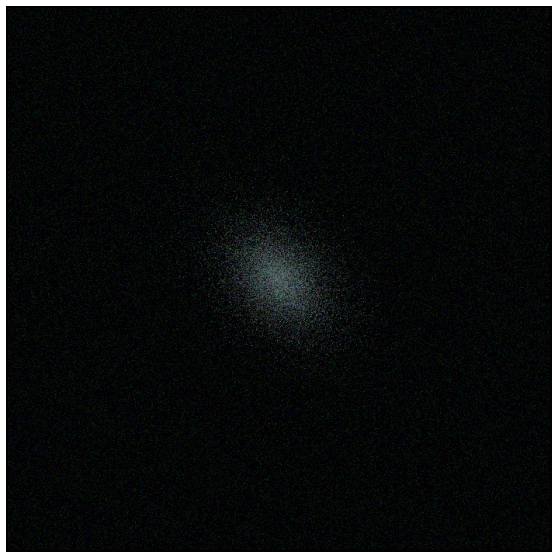

In [ ]:
# PSF with 0.6'' seeing
psf = art.moffat_psf(fwhm=0.1*u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'GALEX_NUV',  # bandpass of observation
    exptime = 10 * u.min, # exposure time
    sky_sb = 27,          # sky surface brightness
    psf = psf             # point spread function
)
obs_r = imager.observe(src, 'GALEX_NUV', 10 * u.min, sky_sb=27, psf=psf)
obs_i = imager.observe(src, 'GALEX_FUV', 30 * u.min, sky_sb=27, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

art.show_image(rgb);

In [ ]:
rgb.shape

(701, 701, 3)